# Advanced Linking: Subnetworks and `search_range`

## Introduction

The goal of the linking step is to find the most likely set of assignments that match each feature in the previous frame with its counterpart in the current frame. This is not always trivial: the correct match for a feature is not always the one closest in distance, and some particles disappear or are introduced with each new frame, leaving  features dangling. In theory, doing this for $N$ particles involves evaluating all $N!$ possible sets of assignments, and choosing the best set. 

Such a computation is time-consuming — infeasibly so for more than a few dozen particles. Instead, for each particle in the previous frame, `trackpy` restricts its search of the current frame to a circular region of radius `search_range`, centered on the particle's most likely new position. One supplies an appropriate `search_range` as an arugment to the `link` family of functions, so that for each particle, there will be at most a few candidate features to consider.

The `search_range` technique usually speeds up linking, but it does not solve the basic problem. Consider the following (admittedly pathological) example, in which a grid of points in the first frame (large blue dots) mysteriously shifts and loses particles in the second frame (small green dots).

In [1]:
import trackpy
import numpy as np
import pandas as pd
# change this to %matplotlib notebook for interactive plotting
%matplotlib inline
from matplotlib.pyplot import *   # not recommended usage, but we use it for brevity here

x0 = np.mgrid[-4:5,-4:5].astype(float)
x0[x0 == 0] = np.nan
x0 += np.random.normal(scale=0.05, size=x0.shape)
pts0 = pd.DataFrame(dict(x=x0[0].flatten(), y=x0[1].flatten(), frame=0)).dropna()

x1 = np.mgrid[-4:4,-4:4] + 0.5
x1[x1 == 0.5] = np.nan
x1 += np.random.normal(scale=0.05, size=x1.shape)
pts1 = pd.DataFrame(dict(x=x1[0].flatten(), y=x1[1].flatten(), frame=1)).dropna()

(-5, 5)

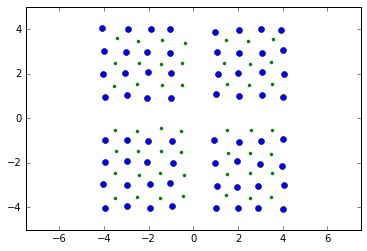

In [2]:
plot(pts0.x, pts0.y, 'bo')
plot(pts1.x, pts1.y, 'g.')
axis('equal')
ylim(-5, 5)

Thanks to a judicious choice of `search_range` (roughly 0.9 would be appropriate), instead of evaluating $\sim N!$ possibilities for the entire frame, we are now left with 4 independent *subnetworks* (or "subnets") of $n$ particles and their $\sim n!$ possibilities. But 
`trackpy` must still decide how to form trajectories within each subnet — how to link the blue and green dots, and which unlucky features from the first frame must go unlinked. If we intuitively assume that particles are unlikely to move by large distances, there is an optimal, most-likely solution. But the problem is generally non-trivial — just try to do it by eye! (For details, see the original paper by Crocker & Grier, referenced in the introduction to the `trackpy` documentation. In general not all $n!$ possibilities are explicitly evaluated, but very many are.)

The preceding example is a little extreme, but non-trivial subnets do arise in many practical tracking applications. Solving subnets is usually the most time-consuming part of the linking process, and can sometimes even make `trackpy`'s algorithm unusable. With certain types of movies, controlling the size of subnets is the central challenge of the linking step.

## Techniques for limiting subnetwork size

In light of this example, there are several `trackpy` features related to this problem at the heart of tracking:

### `search_range`

The `search_range` radius can be adjusted, causing subnets to include more or fewer particles. 

Ideally, `search_range` should be larger than the largest displacement of any particle between successive frames, but smaller than the smallest separation between any two particles. `trackpy` will then typically find just one candidate for each particle's next position, avoiding complex subnetworks altogether. Sometimes this arrangement is possible: the two length scales are very different, and so choosing a `search_range` between them is easy.

When those two scales are closer to each other, or when they vary significantly across the image, there can be problems. To avoid unbearably large subnetworks, one's options for `search_range` are not always practical (or even possible):

- Reduce `search_range` so much that many particles are left untracked or incorrectly tracked.
- Lower the density of particles in the frame.
- Increase the camera framerate (to have smaller displacements between successive frames).
    
Such a dilemma often arises for dense packings of particles.

### Subnetwork size limit

When faced with a subnetwork of $n$ particles, is may be simply unreasonable to consider those $\sim n!$ possibilities. In order to avoid taking hours, days, or weeks to link a single pair of frames, `trackpy` sets a limit on the number of particles $n$ involved in a single subnet computation; if this limit is exceeded, the linking step aborts by raising a `SubnetOversizeException`. This limit is an integer number of particles, stored in `trackpy.linking.Linker.MAX_SUB_NET_SIZE`. Depending on your patience and the speed of your computer, you can adjust this limit, keeping in mind that the time required for these computations generally scales as $n!$.

### Accelerated subnetwork solver

In the tutorial on performance, we briefly discuss how to measure the time spent on subnet computations, and how `trackpy` can use the `numba` package to greatly speed them up. In most cases, you already have `numba` and `trackpy` is using it, but it is worth checking if you are unsure.

### Prediction

The region of radius `search_range` is centered on what `trackpy` guesses as the most likely future position for the particle. Improving this guess may allow one to use a smaller `search_range`. This is called *prediction* and is the subject of one of the tutorials.

### Adaptive search

Rather than having to choose a single value of `search_range` for the entire image (with its attendant tradeoffs), one can specify a *maximum* value, and let `trackpy` reduce it where necessary. This essentially gives `trackpy` license to ignore some potentially valid candidates, but only when the alternative is to halt with a `SubnetOversizeException`. It is a "scalpel" approach, as opposed to the usual hatchet of repeatedly cutting the global `search_range` and retrying linking until a `SubnetOversizeException` is no longer raised. This feature is called *adaptive search* and is discussed in its own tutorial.